# Libraries importing

In [59]:
from scipy.stats import randint

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Data loading and columns selection

In [60]:
selected_columns = ['age', 'stroke', 'hypertension', 'heart_disease', 'avg_glucose_level', 'ever_married', 'work_type',  'smoking_status',]

df = pd.read_csv('data/processed_data.csv')
df = df[selected_columns]

df_naive = pd.read_csv('data/processed_data_copy.csv')
df.head()

,age,stroke,hypertension,heart_disease,avg_glucose_level,ever_married,work_type,smoking_status
0,6.0,1,0,1,0.594096,1,2,1
1,5.0,1,0,0,0.594096,1,3,2
2,7.0,1,0,1,0.583954,1,2,2
3,4.0,1,0,0,0.594096,1,2,3
4,7.0,1,1,0,0.594096,1,3,2


# Data splitting

In [61]:
x = df.drop('stroke', axis=1)
y = df['stroke']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_naive = df_naive.drop('stroke', axis=1)
y_naive = df_naive['stroke']
x_train_naive, x_test_naive, y_train_naive, y_test_naive = train_test_split(x_naive, y_naive, test_size=0.2)

# Decision Tree Model

In [62]:
model = DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=30)
model.fit(x_train, y_train)
predictions = model.predict(x_test)

accuracy = accuracy_score(y_test, predictions)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.97      0.79      0.87       970
           1       0.12      0.52      0.19        52

    accuracy                           0.78      1022
   macro avg       0.54      0.66      0.53      1022
weighted avg       0.93      0.78      0.84      1022



# Decision Tree Visualization

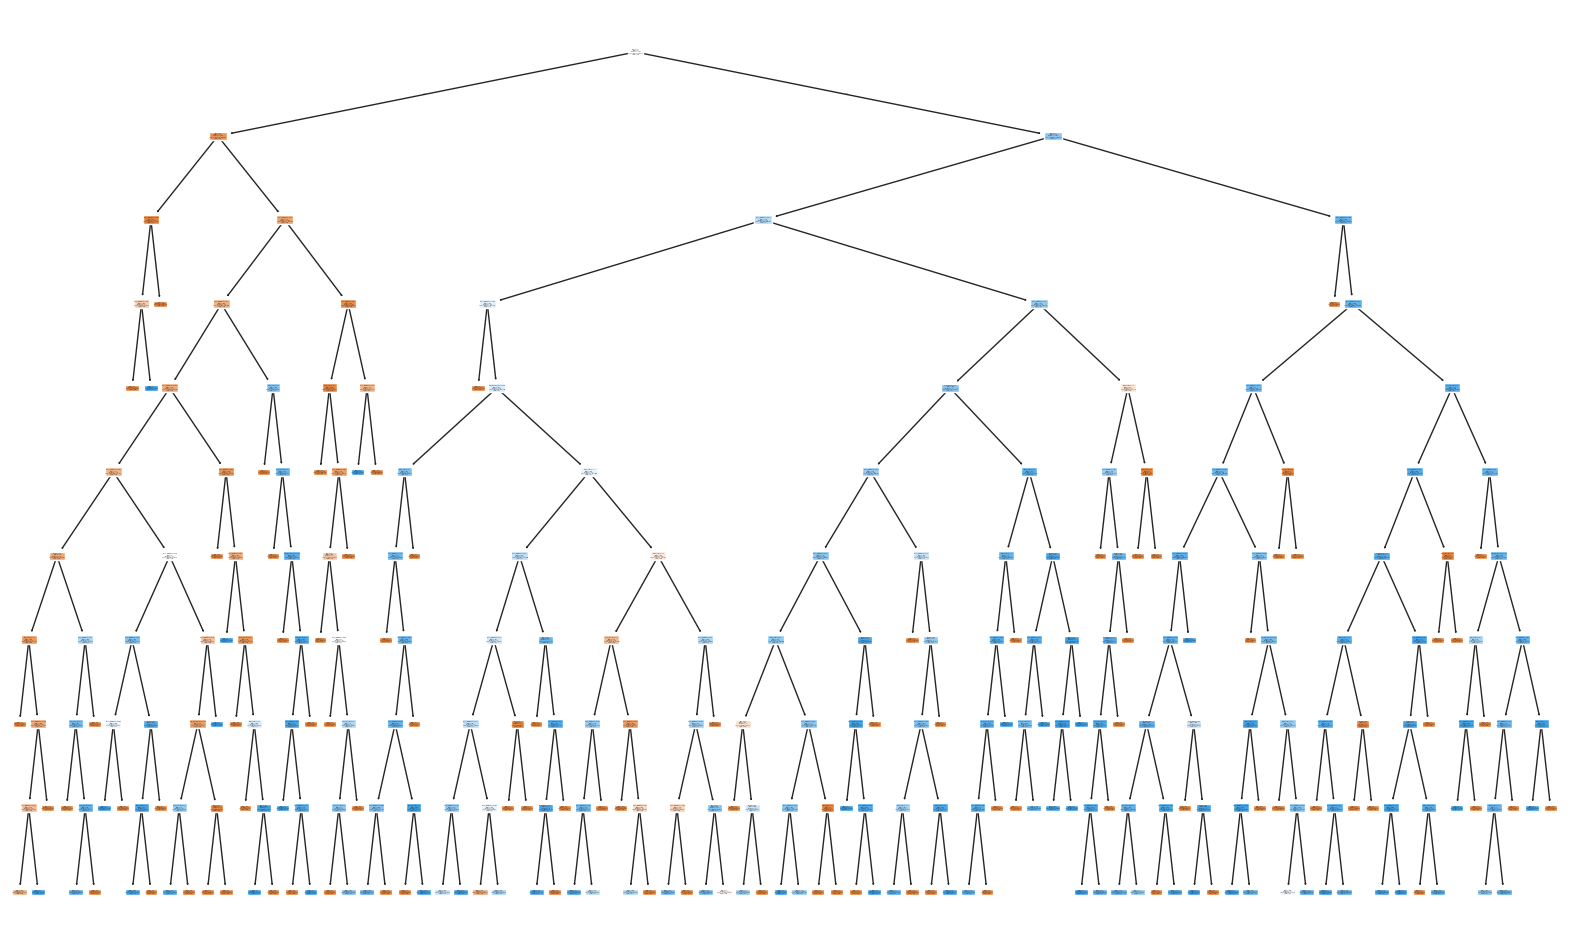

In [63]:
plt.figure(figsize=(20, 12))
plot_tree(model, filled=True, feature_names=selected_columns, class_names=True)
plt.savefig('tree.png')
plt.show()

# Random Forest Model

In [64]:
RF_model = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=30, min_samples_split= 5, min_samples_leaf=1 )
RF_model.fit(x_train, y_train)
RF_predictions = RF_model.predict(x_test)
print(classification_report(y_test, RF_predictions))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       970
           1       0.38      0.10      0.15        52

    accuracy                           0.95      1022
   macro avg       0.67      0.54      0.56      1022
weighted avg       0.92      0.95      0.93      1022



# Hyperparameter Tuning for Random Forest

In [65]:
# # Define a parameter grid for tuning
# param_grid = {
#     'n_estimators': [ 300,400,500,1000],
#     'max_depth': [None, 5, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }
#
# # Set up GridSearchCV
# grid_search = GridSearchCV(
#     estimator=RF_model,
#     param_grid=param_grid,
#     cv=4,                 # 4-fold cross-validation
#     n_jobs=-1,            # use all CPU cores
#     verbose=2,
#     scoring='f1'
# )
#
# # Run grid search
# grid_search.fit(x_train, y_train)
#
# # Best parameters and model
# print("Best Parameters:", grid_search.best_params_)
# print("Best CV Score:", grid_search.best_score_)
#
# # Evaluate on test set
# best_model = grid_search.best_estimator_
# test_score = best_model.score(x_test, y_test)
# print("Test Set Accuracy:", test_score)

# KNN Classifier

In [89]:
knclassifier = KNeighborsClassifier( n_neighbors=11, leaf_size=45, p=1, weights='uniform')
knclassifier.fit(x_train, y_train)
knn_predictions = knclassifier.predict(x_test)
print(classification_report(y_test, knn_predictions))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       970
           1       0.33      0.02      0.04        52

    accuracy                           0.95      1022
   macro avg       0.64      0.51      0.50      1022
weighted avg       0.92      0.95      0.93      1022



In [67]:
param_dist = {
    'n_neighbors': randint(1, 50),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': randint(10, 60)
}

# Random Search
random_search = RandomizedSearchCV(
    estimator=knclassifier,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=30
)

random_search.fit(x_train, y_train)


print("Best Params:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


y_pred = random_search.predict(x_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Best Params: {'leaf_size': 45, 'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}
Best Score: 0.951798726930478
Test Accuracy: 0.949119373776908


# Naive Bayes Classifier

In [68]:
nbclassifier = GaussianNB()
nbclassifier.fit(x_train_naive, y_train_naive)
nb_predictions = nbclassifier.predict(x_test_naive)
print(classification_report(y_test, nb_predictions))


              precision    recall  f1-score   support

           0       0.95      0.88      0.91       970
           1       0.05      0.12      0.07        52

    accuracy                           0.84      1022
   macro avg       0.50      0.50      0.49      1022
weighted avg       0.90      0.84      0.87      1022

